# 🚧🚧 Under construction 🏗️👷 - Memory 1 Heterogeneous Agents 🚧🚧

In [5]:
from pyCRLD.Environments.Base import ebase

from fastcore.utils import *
from fastcore.test import *

from pyCRLD.Environments.HeterogeneousObservationsEnv import HeterogeneousObservationsEnv
from pyCRLD.Environments.MultipleObsSocialDilemma import MultipleObsSocialDilemma

from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Utils import FlowPlot as fp

from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded, ObsActHistsIx, hOset

import numpy as np
import matplotlib.pyplot as plt

In [6]:
def generate_obs_matrix_from_obs_set(descriptions):
    num_states = len(descriptions)  # Total number of states
    matrix = np.zeros((num_states, num_states))  # Initialize the observation matrix

    # Iterate over each description for both observed and comparing state
    for i, observed_desc in enumerate(descriptions):
        observed_parts = observed_desc.strip('|').split(',')
        for j, comparing_desc in enumerate(descriptions):
            comparing_parts = comparing_desc.strip('|').split(',')
            match = True  # Assume it's a match until proven otherwise
            
            # Check for full observability in the observed description
            full_obs = all(part != '.' for part in observed_parts)
            
            if full_obs:
                # Direct comparison for fully observable states
                match = observed_parts == comparing_parts
            else:
                # For partially observable states, '.' is treated as a wildcard
                for obs_part, comp_part in zip(observed_parts, comparing_parts):
                    if obs_part != '.' and obs_part != comp_part:
                        match = False
                        break
            
            # Assigning probability based on the match
            matrix[i, j] = 1 if match else 0

    # Normalize the probabilities in each row
    for i in range(num_states):
        row_sum = np.sum(matrix[i])
        if row_sum > 0:
            matrix[i] /= row_sum

    return matrix

In [7]:
# Create a fully observable environment
env = MultipleObsSocialDilemma(rewards=1.0, temptations=1.2, suckers_payoffs=-0.5, punishments=0, observation_value=[1, 1])
# Define a history object
memo_ipd = HistoryEmbedded(env, h=(1,1,1))

#### Agents only remember what they did: c,., c,., d,. d,. and .,c, .,d, .,c, .,d

In [8]:
# Edit the Oset manually
# Here we're specifying agent1 to only see what they did in the first two iterations of the game
memo_ipd.Oset[0] = ['c,.,.|', 'c,.,.|', 'd,.,.|', 'd,.,.|']
memo_ipd.Oset[1] = ['.,c,.|', '.,d,.|', '.,c,.|', '.,d,.|']
memo_ipd.Oset

[['c,.,.|', 'c,.,.|', 'd,.,.|', 'd,.,.|'],
 ['.,c,.|', '.,d,.|', '.,c,.|', '.,d,.|']]

In [11]:
# Use the above function to define a new observation matrix and output the result into the agent
# previously modified
memo_ipd.O[0] = generate_obs_matrix_from_obs_set(memo_ipd.Oset[0])
memo_ipd.O[1] = generate_obs_matrix_from_obs_set(memo_ipd.Oset[1])

In [12]:
memo_ipd.O

array([[[0.5, 0.5, 0. , 0. ],
        [0.5, 0.5, 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0. , 0.5, 0.5]],

       [[0.5, 0. , 0.5, 0. ],
        [0. , 0.5, 0. , 0.5],
        [0.5, 0. , 0.5, 0. ],
        [0. , 0.5, 0. , 0.5]]])

In [13]:
# Modify state set, so it represents the current game
state_set = []
for i in range(len(memo_ipd.Oset[0])):
    sub_set = f"a0 = {memo_ipd.Oset[0][i]} a1 = {memo_ipd.Oset[1][i]}"
    state_set.append(sub_set)
state_set

['a0 = c,.,.| a1 = .,c,.|',
 'a0 = c,.,.| a1 = .,d,.|',
 'a0 = d,.,.| a1 = .,c,.|',
 'a0 = d,.,.| a1 = .,d,.|']

In [14]:
# Generate agents
mae = POstratAC(env=memo_ipd, learning_rates=0.1, discount_factors=0.9)

 [plot] generating data 99 %   

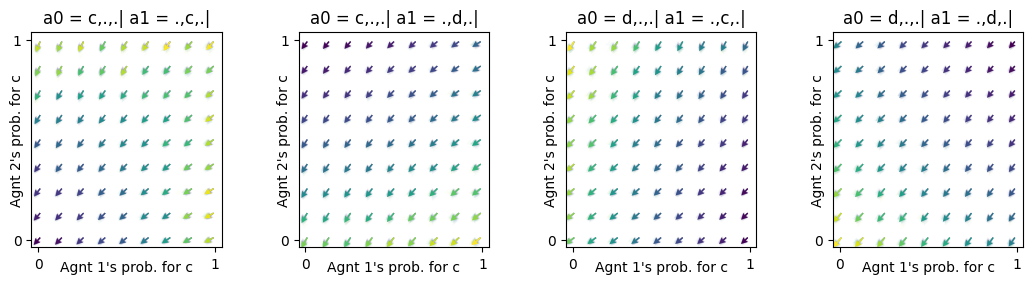

In [15]:
# We can now run the plot generation with the correct labels and obs. matrixes
x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])
ax = fp.plot_strategy_flow(mae, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=state_set, verbose=True)

In [16]:
x = mae.random_softmax_strategy()

In [23]:
x

Array([[[0.2395382 , 0.7604618 ],
        [0.34869707, 0.65130293],
        [0.4679798 , 0.5320202 ],
        [0.75224733, 0.24775265]],

       [[0.1778881 , 0.8221119 ],
        [0.35416943, 0.6458306 ],
        [0.7438034 , 0.2561966 ],
        [0.08297592, 0.9170241 ]]], dtype=float32)

In [26]:
timeseries, fpr = mae.trajectory(x, Tmax=10000, tolerance=10e-6)

In [27]:
timeseries.shape

(220, 2, 4, 2)

Text(0, 0.5, 'cooperation probability')

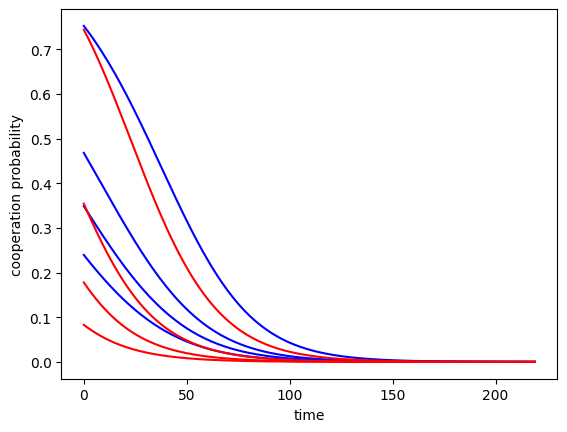

In [20]:
plt.plot(timeseries[:, 0, :, 0], color='blue', label='agent0')
plt.plot(timeseries[:, 1, :, 0], color='red', label='agent1')
plt.xlabel('time'); plt.ylabel('cooperation probability')

In [22]:
Rti = np.array([mae.Ri(x) for x in timeseries])
plt.plot(Rti[:, 0], color='blue', label='agent0')
plt.plot(Rti[:, 1], color='red', label='agent1')
plt.xlabel('time'); plt.ylabel('average reward')

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[4,4].
The error occurred while tracing the function Ri at /Users/mariana/dev/pyCRLD/pyCRLD/Agents/POBase.py:288 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:i32[][39m = convert_element_type[new_dtype=int32 weak_type=True] b
    from line /Users/mariana/dev/pyCRLD/pyCRLD/Agents/POBase.py:336 (_obsdist)

  operation a[35m:i32[][39m = convert_element_type[new_dtype=int32 weak_type=True] b
    from line /Users/mariana/dev/pyCRLD/pyCRLD/Agents/POBase.py:336 (_obsdist)

  operation a[35m:i32[][39m = convert_element_type[new_dtype=int32 weak_type=True] b
    from line /Users/mariana/dev/pyCRLD/pyCRLD/Agents/POBase.py:336 (_obsdist)

  operation a[35m:i32[][39m = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /Users/mariana/dev/pyCRLD/pyCRLD/Agents/POBase.py:336 (_obsdist)

  operation a[35m:bool[][39m = lt b c
    from line /Users/mariana/dev/pyCRLD/pyCRLD/Agents/POBase.py:336 (_obsdist)

(Additional originating lines are not shown.)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError